In [334]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#  Import python wrapper for pitch-by-pitch data from MLB APIs
from pybaseball import statcast

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.linear_model import Lasso, ElasticNet, Ridge

In [ ]:
#  Pull all pitches thrown in 2023 season so far
p_2023 = statcast(start_dt='2023-03-01', end_dt='2023-05-11')

In [33]:
#  Pull all pitches thrown in 2023 season so far
p_2022 = statcast(start_dt='2022-03-01', end_dt='2022-10-01')

This is a large query, it may take a moment to complete


C:\Users\rob\anaconda3\lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [05:18<00:00,  1.58s/it]


In [34]:
p_2022.to_csv('../data/p_2022.csv',index = False)

In [35]:
p_2023.to_csv('../data/p_2023.csv',index = False)

In [98]:
p_2023 = pd.read_csv('../data/p_2023.csv')

In [337]:
may = statcast(start_dt='2023-05-01', end_dt='2023-05-14')

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.28s/it]


In [338]:
may.to_csv('../data/may.csv',index = False)

In [339]:
pitches = may

In [340]:
#  Limit data to combinations where a pitcher has thrown a particular pitch at least 30 times
pitches = pitches[pitches.groupby(['player_name','pitch_type']).transform('size') > 30]

In [341]:
#  View pitch outcome types
pitches['description'].value_counts()

ball                       11010
foul                        6218
hit_into_play               5990
called_strike               5760
swinging_strike             3515
blocked_ball                 627
foul_tip                     370
swinging_strike_blocked      162
hit_by_pitch                  82
foul_bunt                     61
missed_bunt                    9
Name: description, dtype: int64

In [342]:
#  View pitch "event" outcomes 
#  Note:  almost all of these are subcategories of pitches['description'] == 'hit_into_pitch'
pitches['events'].value_counts()

field_out                    3586
strikeout                    1946
single                       1209
walk                          771
double                        399
home_run                      262
force_out                     171
grounded_into_double_play     162
hit_by_pitch                   82
field_error                    51
sac_fly                        46
triple                         26
double_play                    23
sac_bunt                       22
fielders_choice                15
fielders_choice_out            14
caught_stealing_2b             13
strikeout_double_play           8
sac_fly_double_play             4
catcher_interf                  3
wild_pitch                      1
other_out                       1
Name: events, dtype: int64

In [343]:
#  View types of games
pitches['game_type'].value_counts()

R    33804
Name: game_type, dtype: int64

In [344]:
#  Limit inquiry to regular season games
pitches = pitches[pitches['game_type'] == 'R']

In [345]:
#  Dummify pitching hand (1 for Left-handed, 0 for right-handed)
pitches['p_throws'] = pitches['p_throws'].apply(lambda x: 1 if x == 'L' else 0)

We create a feature to distinguish between starting and relief pitchers.  This is important because starting pitchers pitch less frequently, and therefore have longer stamina to remain in a game.  (For more background on the differences between starting and relief pitching, read the descriptions at https://www.mlb.com/glossary/positions/).  

<p>We can reliably identify starters based on the fact that relief pitchers almost never pitch in the 1st inning.  (We will accept the possibility that a pitcher otherwise fitting the profile of a relief pitcher could be mistakenly identified as a starter after being called in during the first inning due to injury or exceptionally poor performance by the starter).

In [346]:
#  Create column for number of pitches thrown to that point on that game
pitches['pitch_no'] = pitches.groupby(['player_name','game_date']).cumcount() + 1

In [347]:
starters = set(pitches.loc[pitches['inning'] == 1,'player_name'])
pitches['starter'] = [1 if player in starters else 0 for player in pitches['player_name']]

We create target variables for outcomes: ball, swinging strike, foul, called strike, out in the field, and hit.  These variables are exhaustive of most, but not all, likely outcomes of a pitch.  In our experience, outcomes not included in these targets are too unlikely to reliably predict based on pitching mechanics, pitch choice, and fatigue alone.

In [348]:
pitches['description'].value_counts()

ball                       11010
foul                        6218
hit_into_play               5990
called_strike               5760
swinging_strike             3515
blocked_ball                 627
foul_tip                     370
swinging_strike_blocked      162
hit_by_pitch                  82
foul_bunt                     61
missed_bunt                    9
Name: description, dtype: int64

In [349]:
pitches['ball'] = pitches['description'].apply(lambda x: 1 if x == 'ball' 
                                               else 1 if x == 'hit_by_pitch'
                                               else 1 if x == 'blocked_ball'
                                               else 1 if x == 'pitchout'
                                               else 0)

pitches['swing'] = pitches['description'].apply(lambda x: 1 if x == 'swinging_strike'
                                                else 1 if x == 'swinging_strike_blocked'
                                                else 1 if x == 'missed_bunt'
                                                else 1 if x == 'foul_tip'
                                                else 0)

pitches['foul'] = pitches['description'].apply(lambda x: 1 if x == 'foul'
                                               else 1 if x == 'foul_bunt'
                                               else 1 if x == 'bunt_foul_tip'
                                               else 0)

pitches['called'] = pitches['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

pitches['out'] = pitches['events'].apply(lambda x: 1 if x == 'field_out' 
                                         else 1 if x == 'grounded_into_double_play'
                                         else 1 if x == 'force_out'
                                         else 1 if x == 'double_play'
                                         else 1 if x == 'sac_fly_double_play'
                                         else 1 if x == 'fielders_choice_out'
                                         else 1 if x == 'fielders_choice'
                                         else 0)

pitches['hit'] = pitches['events'].apply(lambda x: 1 if x == 'single'
                                         else 1 if x == 'double'
                                         else 1 if x == 'triple'
                                         else 1 if x == 'home_run'
                                         else 1 if x == 'sac_fly'
                                         else 1 if x == 'sac_bunt'
                                         else 1 if x == 'field_error'
                                         else 1 if x == 'catcher_interf'
                                         else 0)

In [352]:
pitches['outcome'] = pitches.apply(lambda x: 1 if x['swing'] == 1 
                                   else 2 if x['called'] == 1
                                   else 3 if x['foul'] == 1
                                   else 4 if x['ball'] == 1
                                   else 5 if x['out'] == 1
                                   else 6 if x['hit'] == 1
                                   else 7, axis = 1)

In [353]:
#  View columns with highest null count
pitches.isnull().sum().sort_values(ascending = False).head(50)

umpire                             33804
break_angle_deprecated             33804
tfs_deprecated                     33804
tfs_zulu_deprecated                33804
sv_id                              33804
break_length_deprecated            33804
spin_dir                           33804
spin_rate_deprecated               33804
on_3b                              30615
launch_speed_angle                 27830
estimated_ba_using_speedangle      27830
estimated_woba_using_speedangle    27830
hc_x                               27815
hc_y                               27815
bb_type                            27814
on_2b                              27374
hit_location                       26128
woba_denom                         25005
woba_value                         24989
babip_value                        24989
iso_value                          24989
events                             24989
on_1b                              23741
launch_speed                       22323
launch_angle    

In [354]:
#  Drop columns with nulls > 408
#  release_spin_rate has the highest nulls for any of the remaining columns of interest
pitches.dropna(axis = 1, thresh = 33804-51, inplace = True)

#  Drop remaining rows with nulls
pitches.dropna(axis = 0, inplace = True)

#  Check for any remaining nulls
pitches.isnull().sum().sum()

0

In [355]:
#  Limit data to combinations where a pitcher has thrown a particular pitch at least 30 times
# pitches = pitches[pitches.groupby(['player_name','pitch_type']).transform('size') > 30]

In [356]:
pitches['fatigue'] = pitches['pitch_no'] ** 2

In [357]:
pitches['vz0*2'] = pitches['vz0'] ** 2

In [358]:
pitches['pfx_z*2'] = pitches['pfx_z'] ** 2

In [359]:
pitches['plate_z*2'] = pitches['plate_z'] ** 2

In [366]:
#  Define feature columns
features = ['vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z',
            'ax','ay','az','release_spin_rate','release_extension','effective_speed',
        'release_pos_x','release_pos_y','release_pos_z','sz_top','sz_bot',
            'pitch_type','player_name','pitch_no','inning','fatigue','vz0*2','pfx_z*2','plate_z*2']

In [392]:
#  Define X and y for a model to predict probability of ball

y = pitches['swing'] + pitches['called']
X = pitches[features]

In [393]:
#  Dummify pitch type, but keep original for further preprocessing
X['pitch_type_orig'] = X['pitch_type']
X = pd.get_dummies(X, columns = ['pitch_type'])

C:\Users\rob\AppData\Local\Temp\ipykernel_9140\2939201450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pitch_type_orig'] = X['pitch_type']


In [394]:
#  Split into train and test, target variable = ball
X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, random_state=42)

In [396]:
#  Create '_diff' features which represent the amount of variance 
#  in each feature from the pitcher's mean (temporary '_avg' features) in the training data 
for col in features[:-10]:
    X_train[f'{col}_avg'] = X_train.groupby(['player_name', 'pitch_type_orig'])[col].transform('mean')
    avgs = X_train.groupby(['player_name', 'pitch_type_orig'])[col].mean().reset_index()
    merge = X_test.merge(avgs, on = ['player_name','pitch_type_orig'], how = 'left')
    X_test[f'{col}_avg'] = merge[col + '_y']
    X_train[f'{col}_diff'] = X_train[col] - X_train[f'{col}_avg']
    X_test[f'{col}_diff'] = X_test[col] - X_test[f'{col}_avg']    
    X_train.drop(columns = [f'{col}_avg'])
    X_test.drop(columns = [f'{col}_avg'])

In [397]:
X_train.drop(columns = ['player_name','pitch_type_orig'], inplace = True)

In [398]:
X_test.drop(columns = ['player_name','pitch_type_orig'], inplace = True)

In [399]:
X_test.isnull().sum().sum()

0

In [386]:
#len(X_test.columns)

In [387]:
#combined = pd.concat([X_test, y_test], axis = 1)

In [388]:
#combined.dropna(inplace = True)

In [389]:
#X_test = combined.iloc[:,:len(X_test.columns)]

In [390]:
#y_test = combined.iloc[:,len(X_test.columns):]

In [400]:
#  Save cleaned data to csv
X_train.to_csv('../data/X_train.csv',index = False)
X_test.to_csv('../data/X_test.csv',index = False)
y_train.to_csv('../data/y_train.csv',index = False)
y_test.to_csv('../data/y_test.csv',index = False)

##  Fatigue

<Axes: >

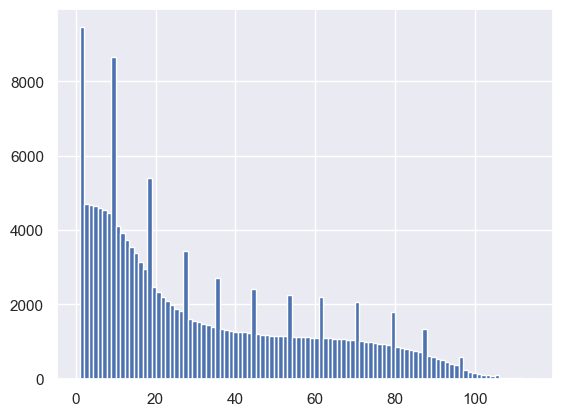

In [92]:
pitches['pitch_no'].hist(bins = 100)

<Axes: xlabel='pitch_no'>

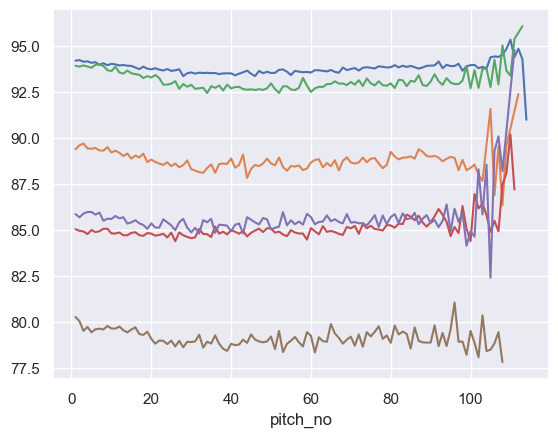

In [61]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['release_speed'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['release_speed'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['release_speed'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['release_speed'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['release_speed'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['release_speed'].mean().plot()

<Axes: xlabel='pitch_no'>

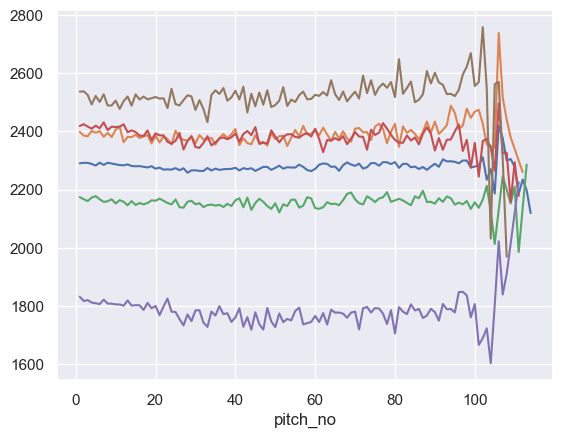

In [62]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['release_spin_rate'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['release_spin_rate'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['release_spin_rate'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['release_spin_rate'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['release_spin_rate'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['release_spin_rate'].mean().plot()

<Axes: xlabel='pitch_no'>

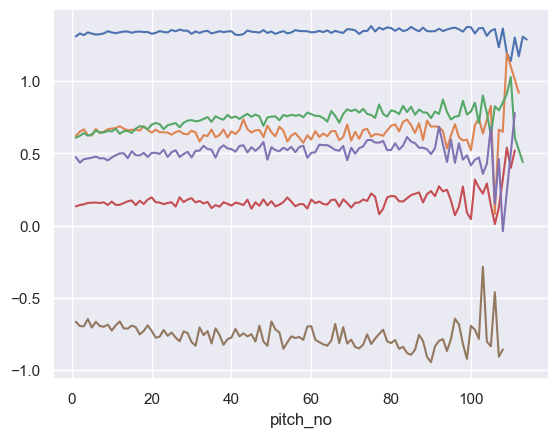

In [63]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['pfx_z'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['pfx_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['pfx_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['pfx_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['pfx_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['pfx_z'].mean().plot()

<Axes: xlabel='pitch_no'>

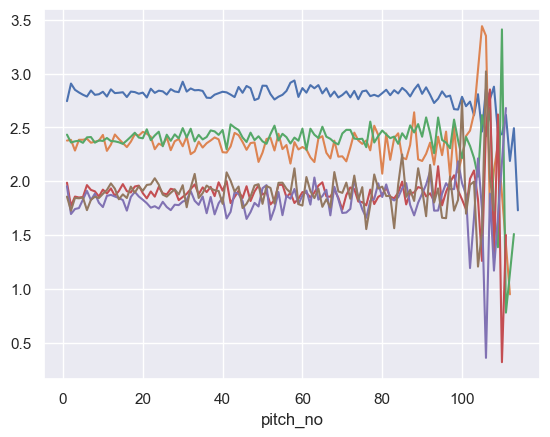

In [102]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['plate_z'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['plate_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['plate_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['plate_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['plate_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['plate_z'].mean().plot()

<Axes: xlabel='pitch_no'>

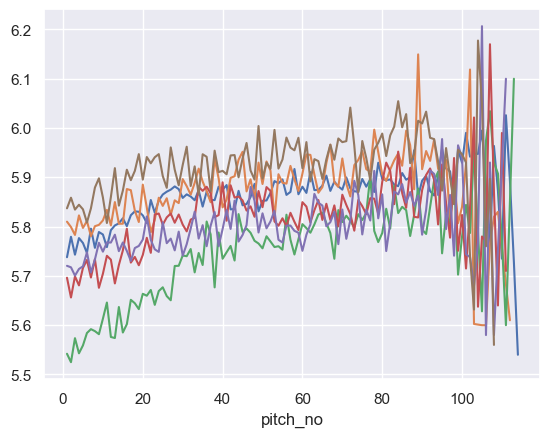

In [64]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['release_pos_z'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['release_pos_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['release_pos_z'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['release_pos_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['release_pos_z'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['release_pos_z'].mean().plot()

<Axes: xlabel='pitch_no'>

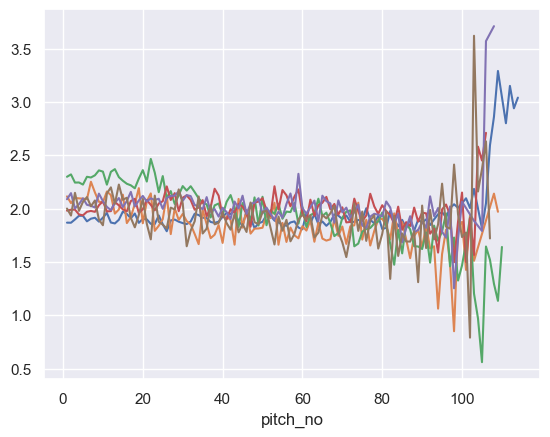

In [104]:
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'FF')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'FC')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'SI')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'SL')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'CH')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'CU')].groupby('pitch_no')['release_pos_x'].mean().plot()

<Axes: xlabel='pitch_no'>

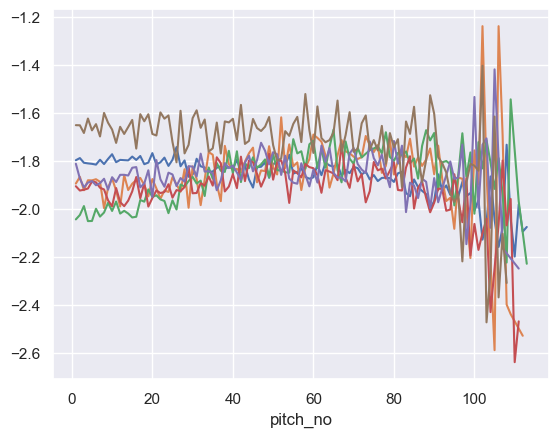

In [105]:
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'FF')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'FC')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'SI')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'SL')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'CH')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'CU')].groupby('pitch_no')['release_pos_x'].mean().plot()

<Axes: xlabel='pitch_no'>

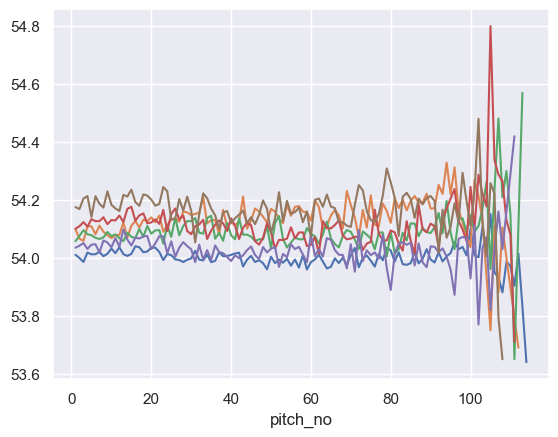

In [93]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['release_pos_y'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['release_pos_y'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['release_pos_y'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['release_pos_y'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['release_pos_y'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['release_pos_y'].mean().plot()

<Axes: xlabel='pitch_no'>

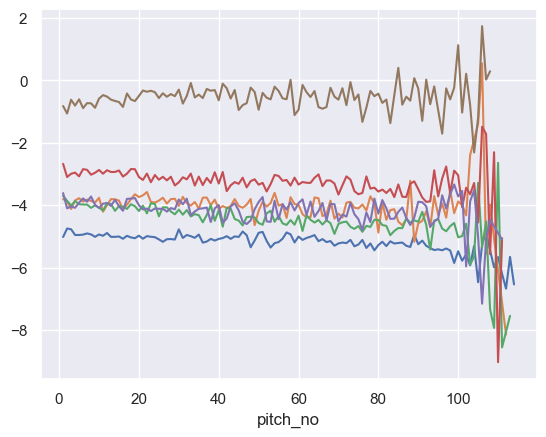

In [97]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['vz0'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['vz0'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['vz0'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['vz0'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['vz0'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['vz0'].mean().plot()

<Axes: xlabel='pitch_no'>

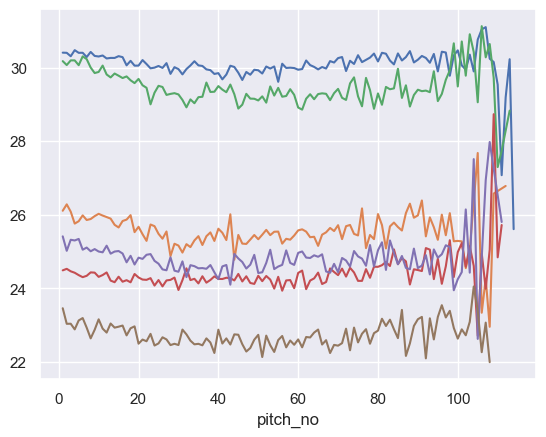

In [99]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['ay'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['ay'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['ay'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['ay'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['ay'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['ay'].mean().plot()

<Axes: xlabel='pitch_no'>

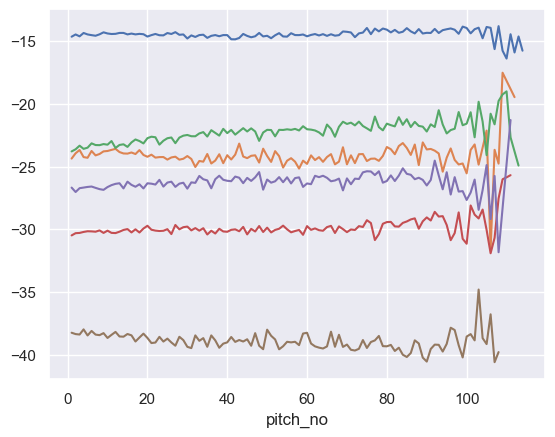

In [100]:
pitches[pitches['pitch_type'] == 'FF'].groupby('pitch_no')['az'].mean().plot()
pitches[pitches['pitch_type'] == 'FC'].groupby('pitch_no')['az'].mean().plot()
pitches[pitches['pitch_type'] == 'SI'].groupby('pitch_no')['az'].mean().plot()
pitches[pitches['pitch_type'] == 'SL'].groupby('pitch_no')['az'].mean().plot()
pitches[pitches['pitch_type'] == 'CH'].groupby('pitch_no')['az'].mean().plot()
pitches[pitches['pitch_type'] == 'CU'].groupby('pitch_no')['az'].mean().plot()

##  Exploring Mechanical Measurements of Common Pitch Types

<Axes: xlabel='pitch_no'>

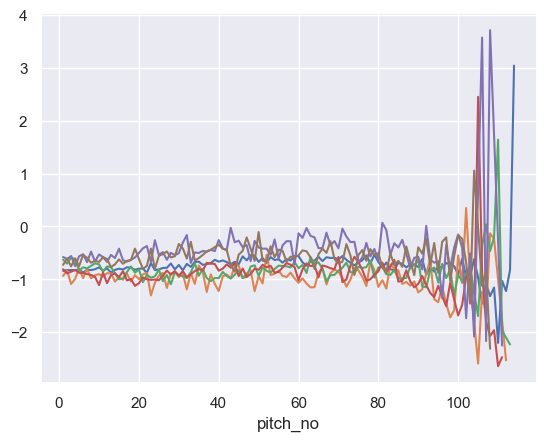

In [66]:
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'FF')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'FC')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'SI')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'SL')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'CH')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 0) & (pitches['pitch_type'] == 'CU')].groupby('pitch_no')['release_pos_x'].mean().plot()

###  TL;DR

<Axes: xlabel='pitch_no'>

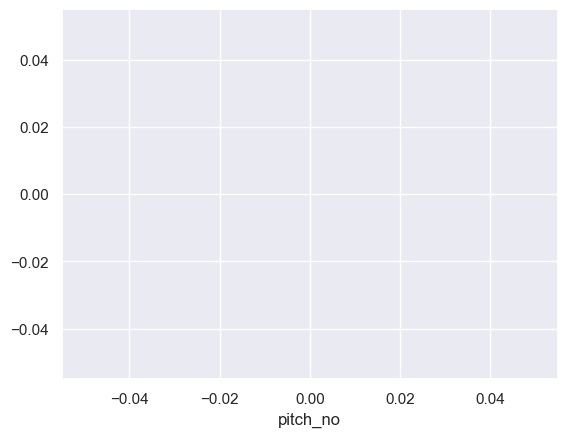

In [68]:
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'FF')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'FC')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'SI')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'SL')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'CH')].groupby('pitch_no')['release_pos_x'].mean().plot()
pitches[(pitches['p_throws'] == 1) & (pitches['pitch_type'] == 'CU')].groupby('pitch_no')['release_pos_x'].mean().plot()

In [21]:
#  View codes for pitch types 
pitches['pitch_type'].value_counts()

FF    53456
SL    29574
SI    24658
CH    17657
FC    13112
CU    12179
ST     7438
FS     3491
KC     3210
SV      751
FA      269
FO      140
EP       44
SC       28
CS        9
FT        7
Name: pitch_type, dtype: int64

In [20]:
#  View names of pitch types 
pitches['pitch_name'].value_counts()

4-Seam Fastball    53456
Slider             29574
Sinker             24658
Changeup           17657
Cutter             13112
Curveball          12179
Sweeper             7438
Split-Finger        3491
Knuckle Curve       3210
Slurve               751
Other                269
Forkball             140
Eephus                44
Screwball             28
Slow Curve             9
2-Seam Fastball        7
Name: pitch_name, dtype: int64

### Pitch Type - Speed and Rotation

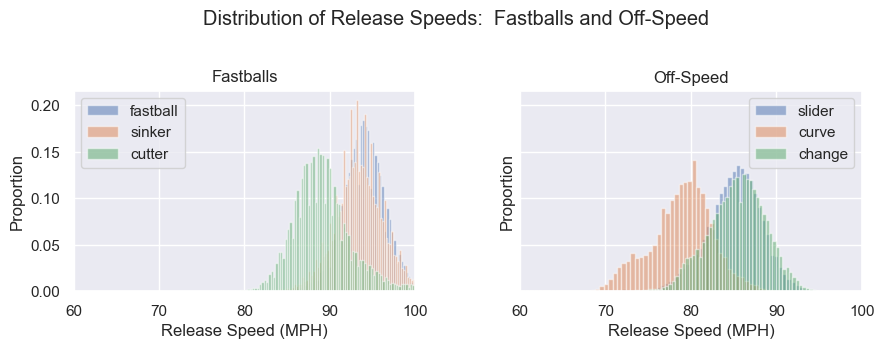

In [15]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 5)
fig.suptitle('Distribution of Release Speeds:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')


axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['release_speed'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Release Speed (MPH)')
axs[1].set_xlabel('Release Speed (MPH)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(60,100)
axs[1].set_xlim(60,100);

Among the 6 most common pitch types, the cutter and sinker are generally considered as variants of the fastball.  The changeup is designed to be deceptive by being thrown in a manner almost identical to a fastball, but at a slightly slower speed.  The slider and curveball are notable not only for their reduced forward velocity, but for their rotation speed and direction that causes greater downward movement (often accompanied by significant horizontal movement as well).  See https://www.mlb.com/glossary/pitch-types for further discussion.

<p>
One surprising observation is that the median speeds of cut fastballs (also knows as "cutters"), changeups, and sliders are fairly similar.

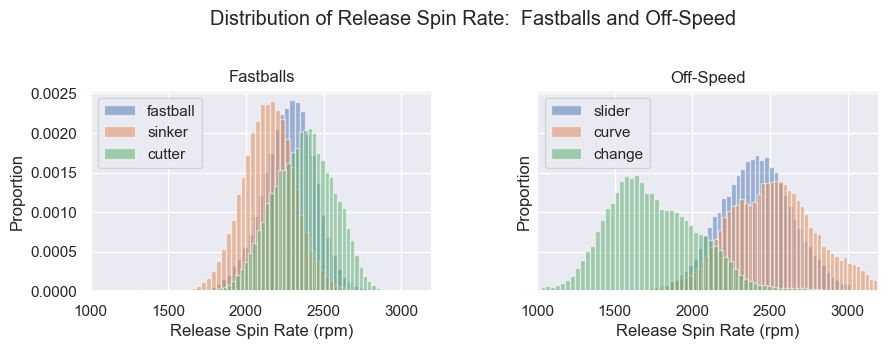

In [16]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 5)
fig.suptitle('Distribution of Release Spin Rate:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['release_spin_rate'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Release Spin Rate (rpm)')
axs[1].set_xlabel('Release Spin Rate (rpm)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(1000,3200)
axs[1].set_xlim(1000,3200);

Fastballs and fastball variants have similar rotational speeds at release, with medians between 2000 and 2300 rpm.  Changeups have significantly less rotation (median around 1700 rpm), while curveballs and sliders have more than fastballs (medians around 2400-2500 rpm)   

###  Pitch Type - Horizontal (x-direction) metrics

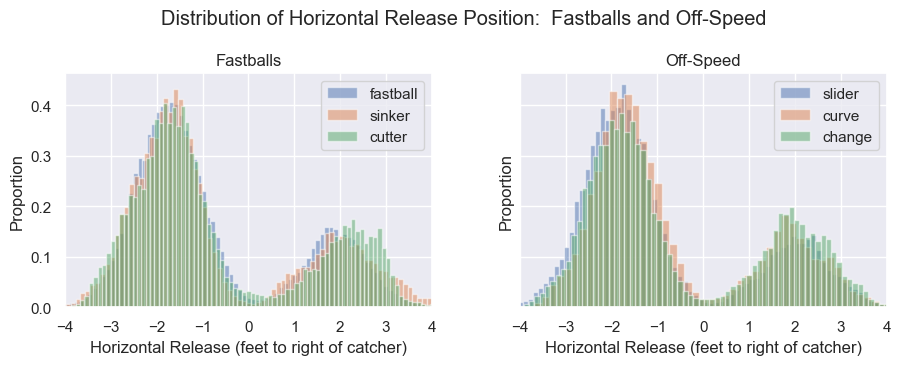

In [27]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Horizontal Release Position:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['release_pos_x'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Horizontal Release (feet to right of catcher)')
axs[1].set_xlabel('Horizontal Release (feet to right of catcher)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-4,4)
axs[1].set_xlim(-4,4);

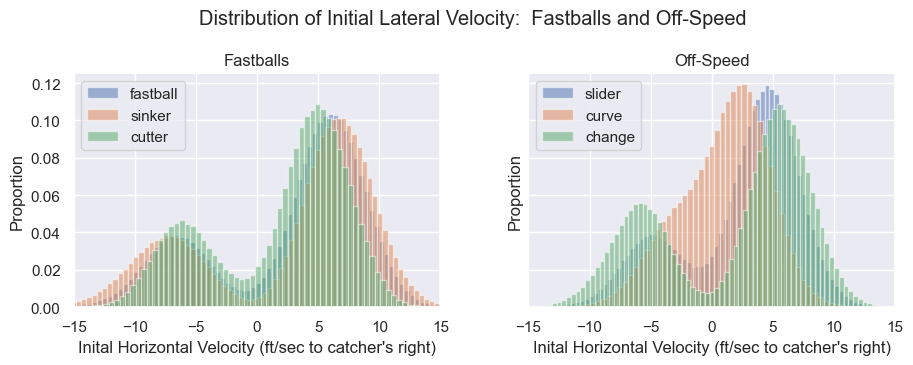

In [28]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Initial Lateral Velocity:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['vx0'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Inital Horizontal Velocity (ft/sec to catcher\'s right)')
axs[1].set_xlabel('Inital Horizontal Velocity (ft/sec to catcher\'s right)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-15,15)
axs[1].set_xlim(-15,15);

(-25.0, 25.0)

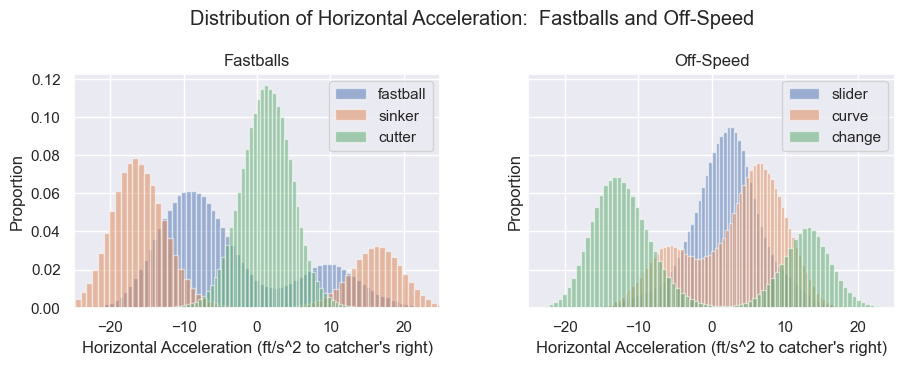

In [29]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Horizontal Acceleration:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['ax'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['ax'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['ax'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['ax'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['ax'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['ax'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Horizontal Acceleration (ft/s^2 to catcher\'s right)')
axs[1].set_xlabel('Horizontal Acceleration (ft/s^2 to catcher\'s right)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-25,25)
axs[1].set_xlim(-25,25)

### Pitch Type - Forward (y-direction) metrics

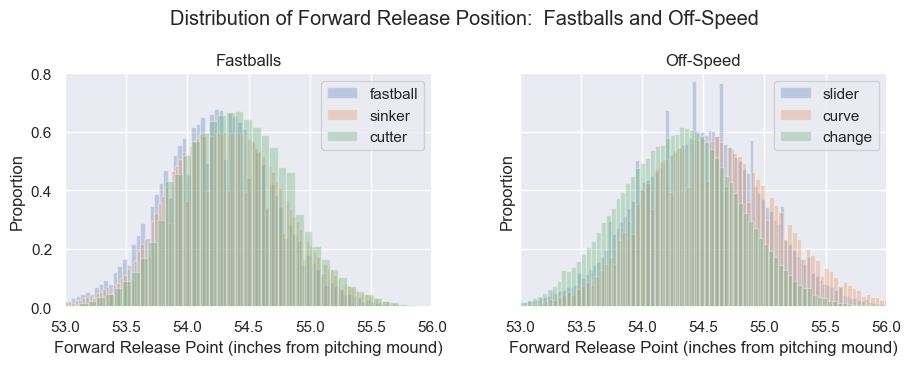

In [30]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Forward Release Position:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'fastball',
            bins = 200)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'sinker',
            bins = 300)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'cutter',
            bins = 400)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'slider',
            bins = 300)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'curve',
            bins = 200)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['release_pos_y'],
            alpha = 0.3,
            density = True,
            label = 'change',
            bins = 200)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Forward Release Point (inches from pitching mound)')
axs[1].set_xlabel('Forward Release Point (inches from pitching mound)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(53,56)
axs[1].set_xlim(53,56)

axs[0].set_ylim(0,0.8)
axs[1].set_ylim(0,0.8);

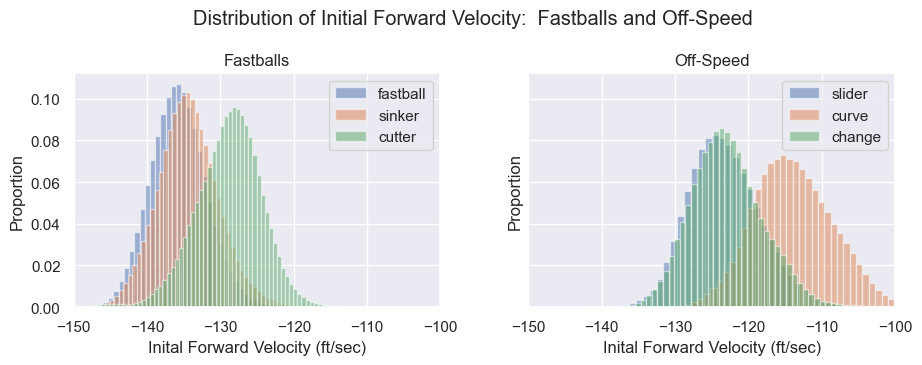

In [31]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Initial Forward Velocity:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['vy0'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Inital Forward Velocity (ft/sec)')
axs[1].set_xlabel('Inital Forward Velocity (ft/sec)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-150,-100)
axs[1].set_xlim(-150,-100);

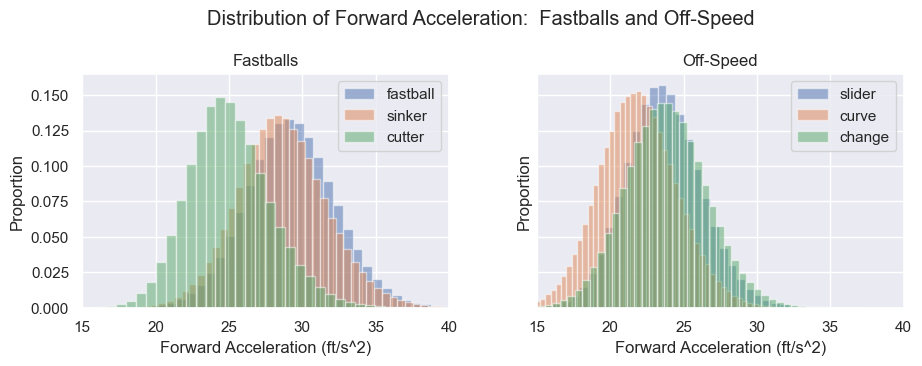

In [32]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Forward Acceleration:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['ay'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['ay'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['ay'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['ay'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['ay'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['ay'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Forward Acceleration (ft/s^2)')
axs[1].set_xlabel('Forward Acceleration (ft/s^2)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(15,40)
axs[1].set_xlim(15,40);

### Pitch Type - Vertical (z-direction) metrics

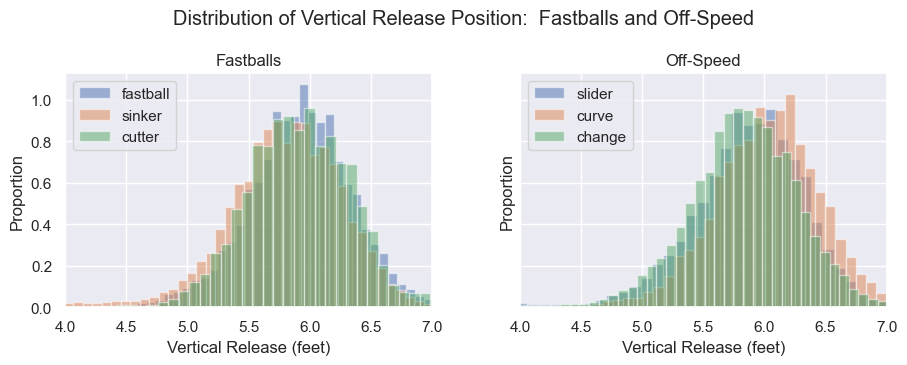

In [33]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Vertical Release Position:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['release_pos_z'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Vertical Release (feet)')
axs[1].set_xlabel('Vertical Release (feet)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(4,7)
axs[1].set_xlim(4,7);

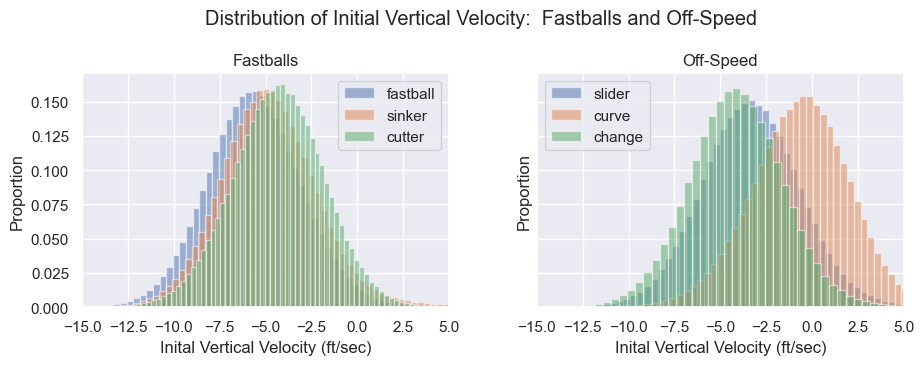

In [34]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Initial Vertical Velocity:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['vz0'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)

axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Inital Vertical Velocity (ft/sec)')
axs[1].set_xlabel('Inital Vertical Velocity (ft/sec)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-15,5)
axs[1].set_xlim(-15,5);

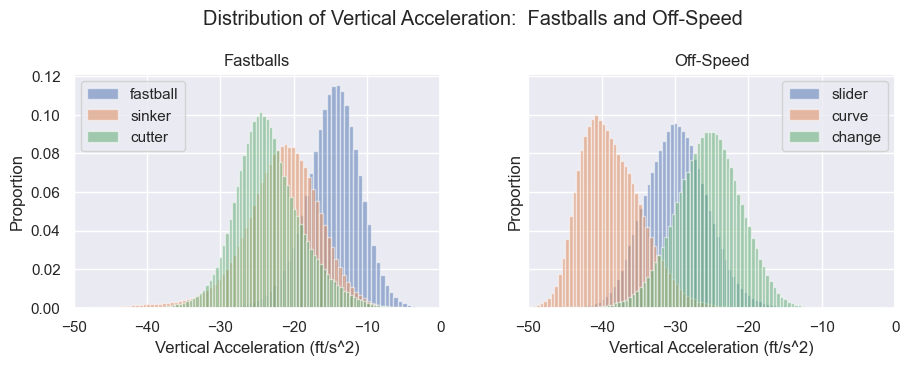

In [35]:
fig, axs = plt.subplots(1,2,figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 4)
fig.suptitle('Distribution of Vertical Acceleration:  Fastballs and Off-Speed')
axs[0].set_title('Fastballs')
axs[1].set_title('Off-Speed')

axs[0].hist(pitches[pitches['pitch_name'] == '4-Seam Fastball']['az'],
            alpha = 0.5,
            density = True,
            label = 'fastball',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Sinker']['az'],
            alpha = 0.5,
            density = True,
            label = 'sinker',
            bins = 100)

axs[0].hist(pitches[pitches['pitch_name'] == 'Cutter']['az'],
            alpha = 0.5,
            density = True,
            label = 'cutter',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Slider']['az'],
            alpha = 0.5,
            density = True,
            label = 'slider',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Curveball']['az'],
            alpha = 0.5,
            density = True,
            label = 'curve',
            bins = 100)

axs[1].hist(pitches[pitches['pitch_name'] == 'Changeup']['az'],
            alpha = 0.5,
            density = True,
            label = 'change',
            bins = 100)
axs[0].legend()
axs[1].legend()

axs[0].set_xlabel('Vertical Acceleration (ft/s^2)')
axs[1].set_xlabel('Vertical Acceleration (ft/s^2)')

axs[0].set_ylabel('Proportion')
axs[1].set_ylabel('Proportion')

axs[0].set_xlim(-50,0)
axs[1].set_xlim(-50,0);

##  Predicting Outcomes Based on Metrics - Fastballs

In [ ]:
'vx0','vy0','vz0','release_speed','pfx_x','pfx_z','plate_x','plate_z','ax','ay','az','release_spin_rate','release_extension','effective_speed',
        'release_pos_x','release_pos_y',

C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1755678742.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['plate_x'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1755678742.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['plate_x'],
C:\Users\rob\anac

''

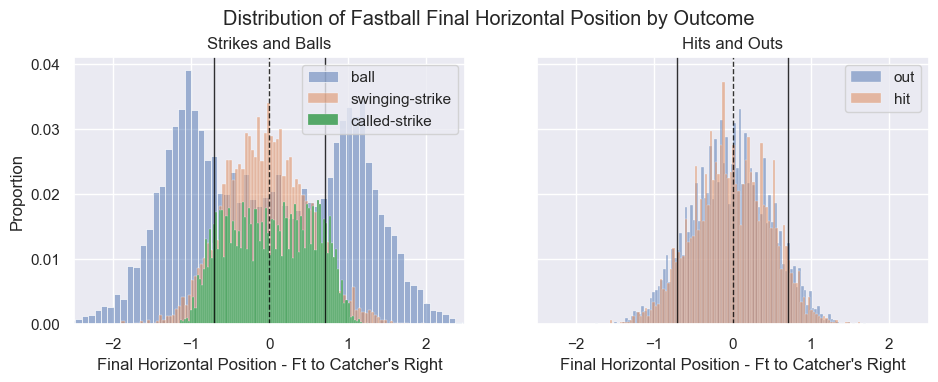

In [87]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Final Horizontal Position by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')
axs[1].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')


axs[0].set_xlim(-2.5,2.5)
axs[1].set_xlim(-2.5,2.5)

axs[0].axvline(x = 8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[0].axvline(x = -8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[0].axvline(x = 0, color = 'black',alpha = 0.8, linestyle = '--',linewidth = 1)
axs[1].axvline(x = 8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = -8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = 0, color = 'black',alpha = 0.8, linestyle = '--',linewidth = 1)

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['plate_x'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['plate_x'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['called'] == 1)]['plate_x'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['out'] == 1)]['plate_x'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['hit'] == 1)]['plate_x'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


(The solid lines represent the edges of home plate, and the dotted line represents the middle of home plate).  
<p>
Here we see that fastballs thrown for balls tend to be significantly to the left or the right of home plate.  Much to the chagrin of hitters, there is a small but significant portion of called strikes which are not actually over home plate.  Swinging strikes tend to be on pitches over home plate, but there is a larger proportion of swinging strikes to the left or right of home plate than called strikes. 
<p>
<p>
The distribution of all fastballs skews ever so slightly to the catcher's left, suggesting an overall trend of throwing fastballs more often to the inside part of the plate against right-handed batters (who represent the vast majority of hitters).
<p>  
The distribution of pitches resulting in a ball hit into the field is also slightly skewed to the left, with the distribution of outs being only slightly more spread than the distribution of hits.  This suggests that a pitch thrown incrementally more to the outside of the plate is only slightly more likely to result in an out than a hit. 

C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1022074343.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['plate_z'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1022074343.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['plate_z'],
C:\Users\rob\anac

''

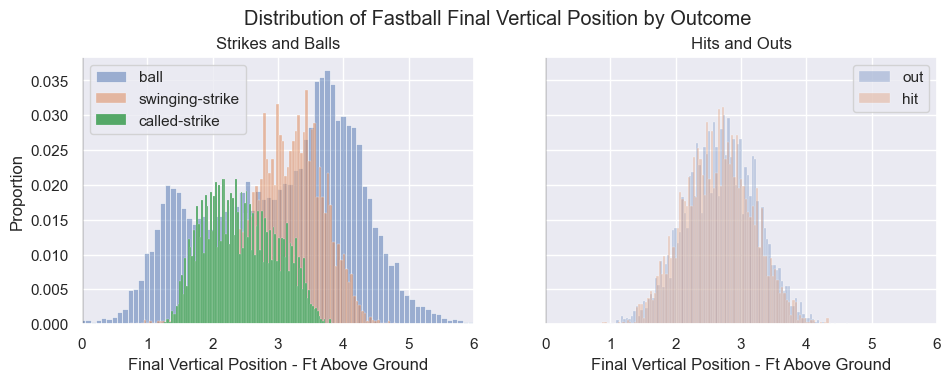

In [83]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Final Vertical Position by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Final Vertical Position - Ft Above Ground')
axs[1].set_xlabel('Final Vertical Position - Ft Above Ground')


axs[0].set_xlim(0,6)
axs[1].set_xlim(0,6)

axs[0].axvline(x = 0, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = 0, color = 'black',alpha = 0.8, linewidth = 1)

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['plate_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['plate_z'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['called'] == 1)]['plate_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['out'] == 1)]['plate_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.3,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['hit'] == 1)]['plate_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.3,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1311148891.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_speed'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1311148891.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_speed'],
C:\Us

''

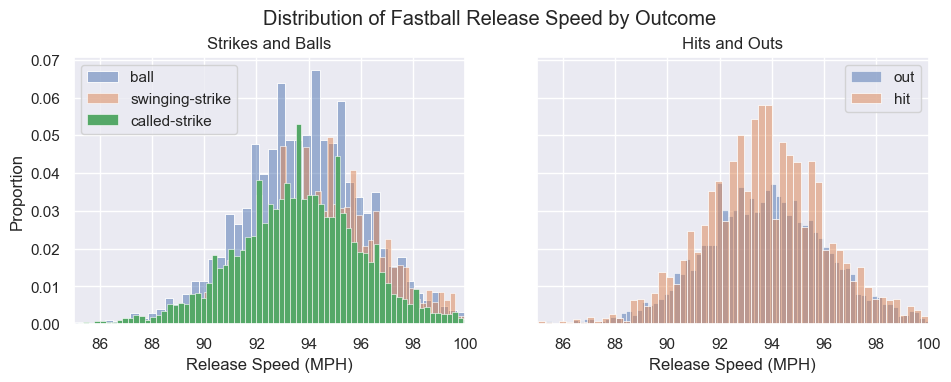

In [101]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Release Speed by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Release Speed (MPH)')
axs[1].set_xlabel('Release Speed (MPH)')


axs[0].set_xlim(85,100)
axs[1].set_xlim(85,100)

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_speed'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_speed'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['called'] == 1)]['release_speed'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['out'] == 1)]['release_speed'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['hit'] == 1)]['release_speed'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2736208999.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_spin_rate'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2736208999.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_spin_rate'

''

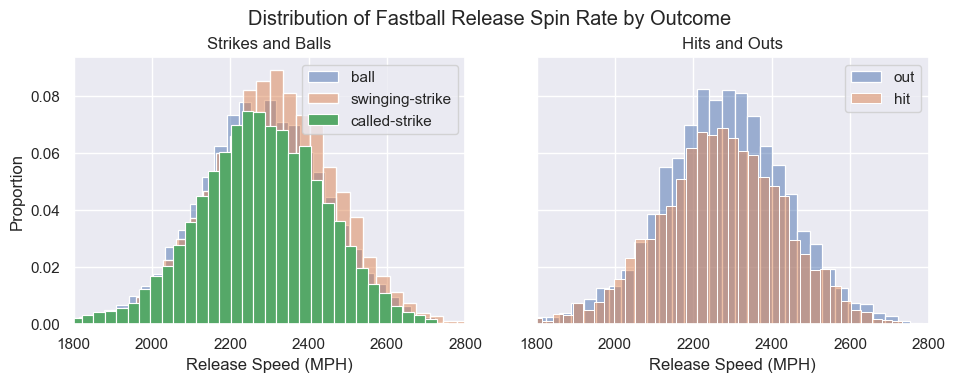

In [104]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Release Spin Rate by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Release Speed (MPH)')
axs[1].set_xlabel('Release Speed (MPH)')

axs[0].set_xlim(1800,2800)
axs[1].set_xlim(1800,2800)


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_spin_rate'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_spin_rate'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['called'] == 1)]['release_spin_rate'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['out'] == 1)]['release_spin_rate'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
  #           common_norm = False,
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['hit'] == 1)]['release_spin_rate'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
   #          common_norm = False,
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\908140723.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') &
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\908140723.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') &
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a f

''

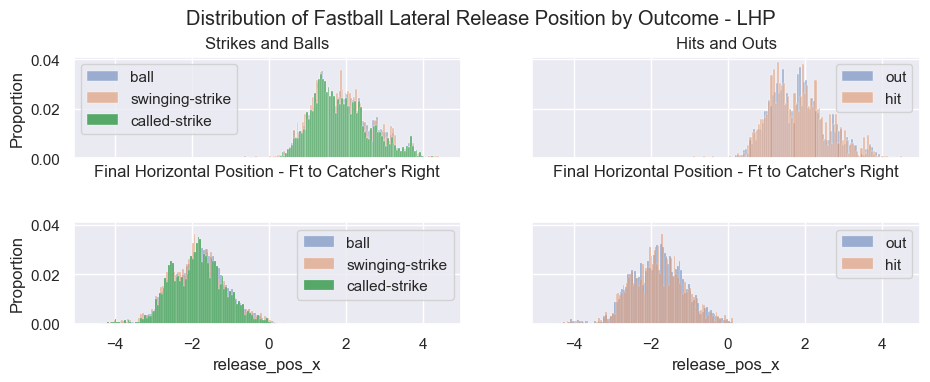

In [116]:
fig, axs = plt.subplots(2,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Lateral Release Position by Outcome - LHP')

axs[0,0].set_title('Strikes and Balls')
axs[0,1].set_title('Hits and Outs')

axs[0,0].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')
axs[0,1].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')


#axs[0].set_xlim(-2.5,2.5)
#axs[1].set_xlim(-2.5,2.5)

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 1) &
                     (pitches['ball'] == 1)]['release_pos_x'],
             ax = axs[0,0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 1) &
                     (pitches['swing'] == 1)]['release_pos_x'],
             ax = axs[0,0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 1) &
                     (pitches['called'] == 1)]['release_pos_x'],
             ax = axs[0,0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 1) &
                     (pitches['out'] == 1)]['release_pos_x'],
             ax = axs[0,1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 1) &
                     (pitches['hit'] == 1)]['release_pos_x'],
             ax = axs[0,1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 0) &
                     (pitches['ball'] == 1)]['release_pos_x'],
             ax = axs[1,0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 0) &
                     (pitches['swing'] == 1)]['release_pos_x'],
             ax = axs[1,0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 0) &
                     (pitches['called'] == 1)]['release_pos_x'],
             ax = axs[1,0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 0) &
                     (pitches['out'] == 1)]['release_pos_x'],
             ax = axs[1,1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & 
                     (pitches['p_throws'] == 0) &
                     (pitches['hit'] == 1)]['release_pos_x'],
             ax = axs[1,1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')


handles1, labels1 = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[0,1].get_legend_handles_labels()
axs[0,1].legend(handles = handles2, labels = labels2)

handles3, labels3 = axs[1,0].get_legend_handles_labels()
axs[1,0].legend(handles = handles3, labels = labels3)

handles4, labels4 = axs[1,1].get_legend_handles_labels()
axs[1,1].legend(handles = handles4, labels = labels4)



;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2738257616.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_pos_z'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2738257616.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_pos_z'],
C:\Us

''

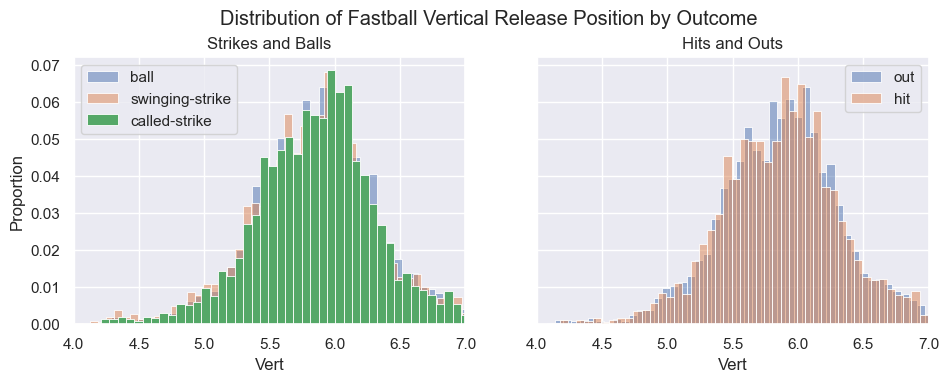

In [119]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Fastball Vertical Release Position by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Vert')
axs[1].set_xlabel('Vert')

axs[0].set_xlim(4,7)
axs[1].set_xlim(4,7)


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['ball'] == 1)]['release_pos_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['swing'] == 1)]['release_pos_z'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['called'] == 1)]['release_pos_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['out'] == 1)]['release_pos_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
  #           common_norm = False,
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'FF') & (pitches['hit'] == 1)]['release_pos_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
   #          common_norm = False,
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


##  Predict Outcomes Based on Metrics - Curveball

We next move on to the curveball, whose effectiveness is based on factors most distinct from the fastball

C:\Users\rob\AppData\Local\Temp\ipykernel_21844\141626275.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['plate_x'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\141626275.py:33: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['plate_x'],
C:\Users\rob\anacon

''

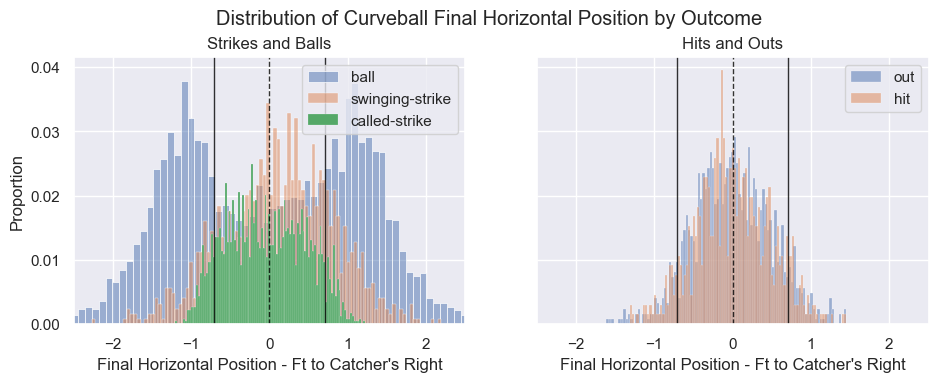

In [105]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Curveball Final Horizontal Position by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')
axs[1].set_xlabel('Final Horizontal Position - Ft to Catcher\'s Right')


axs[0].set_xlim(-2.5,2.5)
axs[1].set_xlim(-2.5,2.5)

axs[0].axvline(x = 8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[0].axvline(x = -8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[0].axvline(x = 0, color = 'black',alpha = 0.8, linestyle = '--',linewidth = 1)
axs[1].axvline(x = 8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = -8.5/12, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = 0, color = 'black',alpha = 0.8, linestyle = '--',linewidth = 1)

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['plate_x'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['plate_x'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['called'] == 1)]['plate_x'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['out'] == 1)]['plate_x'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['hit'] == 1)]['plate_x'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


(The solid lines represent the edges of home plate, and the dotted line represents the middle of home plate).  
<p>
Here we see that fastballs thrown for balls tend to be significantly to the left or the right of home plate.  Much to the chagrin of hitters, there is a small but significant portion of called strikes which are not actually over home plate.  Swinging strikes tend to be on pitches over home plate, but there is a larger proportion of swinging strikes to the left or right of home plate than called strikes. 
<p>
<p>
The distribution of all fastballs skews ever so slightly to the catcher's left, suggesting an overall trend of throwing fastballs more often to the inside part of the plate against right-handed batters (who represent the vast majority of hitters).
<p>  
The distribution of pitches resulting in a ball hit into the field is also slightly skewed to the left, with the distribution of outs being only slightly more spread than the distribution of hits.  This suggests that a pitch thrown incrementally more to the outside of the plate is only slightly more likely to result in an out than a hit. 

C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1209367288.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['plate_z'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\1209367288.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['plate_z'],
C:\Users\rob\anac

''

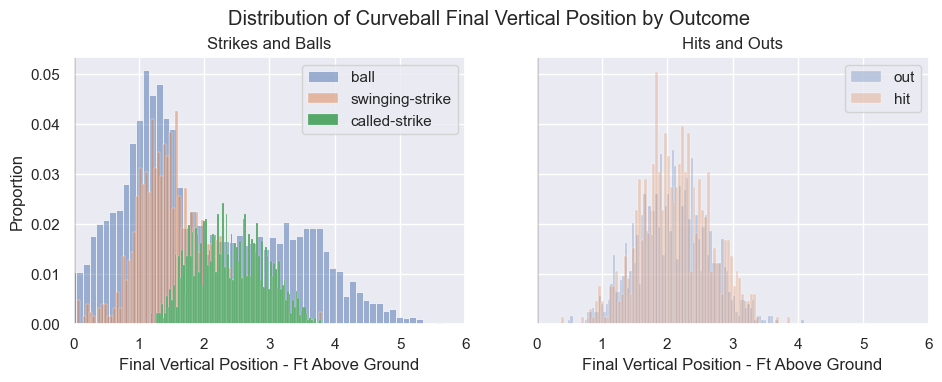

In [106]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Curveball Final Vertical Position by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Final Vertical Position - Ft Above Ground')
axs[1].set_xlabel('Final Vertical Position - Ft Above Ground')


axs[0].set_xlim(0,6)
axs[1].set_xlim(0,6)

axs[0].axvline(x = 0, color = 'black',alpha = 0.8, linewidth = 1)
axs[1].axvline(x = 0, color = 'black',alpha = 0.8, linewidth = 1)

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['plate_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['plate_z'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['called'] == 1)]['plate_z'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['out'] == 1)]['plate_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.3,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['hit'] == 1)]['plate_z'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.3,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2271442591.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['release_speed'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2271442591.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['release_speed'],
C:\Us

''

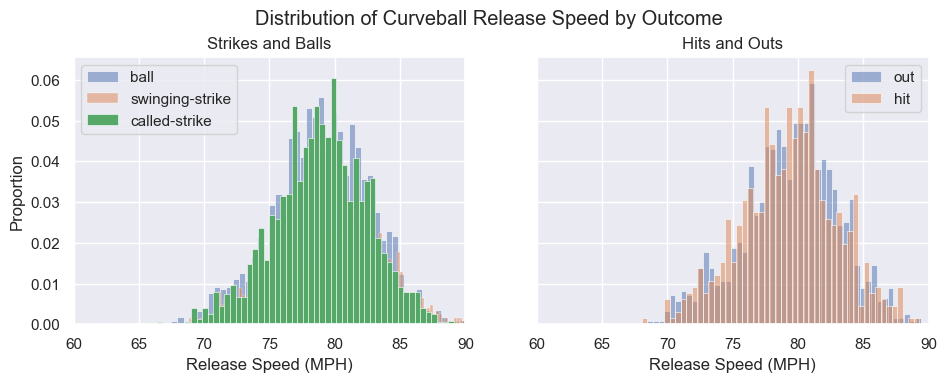

In [108]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Curveball Release Speed by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Release Speed (MPH)')
axs[1].set_xlabel('Release Speed (MPH)')


axs[0].set_xlim(60,90)
axs[1].set_xlim(60,90)

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['release_speed'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['release_speed'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['called'] == 1)]['release_speed'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['out'] == 1)]['release_speed'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['hit'] == 1)]['release_speed'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2416617803.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['release_spin_rate'],
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\rob\anaconda3\lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
C:\Users\rob\AppData\Local\Temp\ipykernel_21844\2416617803.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['release_spin_rate'

''

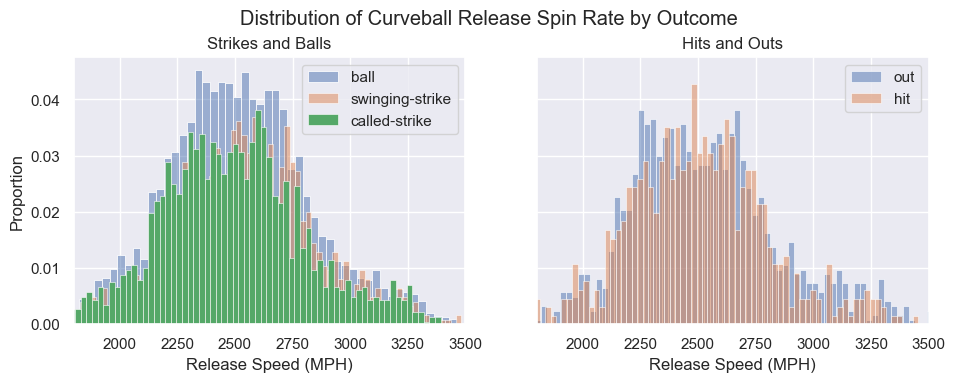

In [110]:
fig, axs = plt.subplots(1,2, figsize= (10,4),
                       sharey = True,
                       sharex = True)

fig.tight_layout(pad = 3)
fig.suptitle('Distribution of Curveball Release Spin Rate by Outcome')

axs[0].set_title('Strikes and Balls')
axs[1].set_title('Hits and Outs')

axs[0].set_xlabel('Release Speed (MPH)')
axs[1].set_xlabel('Release Speed (MPH)')

axs[0].set_xlim(1800,3500)
axs[1].set_xlim(1800,3500)


sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['ball'] == 1)]['release_spin_rate'],
             ax = axs[0],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'ball')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['swing'] == 1)]['release_spin_rate'],
             ax = axs[0],             
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
             label = 'swinging-strike')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['called'] == 1)]['release_spin_rate'],
             ax = axs[0],
             palette = 'dark',
             alpha = 1,
             bins = 100,
             stat = 'proportion',
             label = 'called-strike')


sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['out'] == 1)]['release_spin_rate'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
  #           common_norm = False,
             label = 'out')

sns.histplot(pitches[(pitches['pitch_type'] == 'CU') & (pitches['hit'] == 1)]['release_spin_rate'],
             ax = axs[1],
             palette = 'dark',
             alpha = 0.5,
             bins = 100,
             stat = 'proportion',
   #          common_norm = False,
             label = 'hit')

handles1, labels1 = axs[0].get_legend_handles_labels()
axs[0].legend(handles = handles1, labels = labels1)

handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend(handles = handles2, labels = labels2)


;


In [ ]:
#  predict swinging/called strikes  
# fatigue through at-bat
#  starters vs relievers
#  lefty vs. righty
#  specialist vs non-specialist
#  rule changes

In [ ]:
# lefty